In [1]:
import chess.pgn
import pandas as pd
#import chess

In [2]:
ls -shr

total 90M
 16K README.md                              568K chess.ipynb
 89M lichess_db_standard_rated_2013-01.pgn  276K chess-and-eigenvectors.ipynb


In [3]:
pgn = open('lichess_db_standard_rated_2013-01.pgn',encoding="utf-8")

In [4]:
dict_of_games = {}
counter = 0
while counter < 1000:
    game = chess.pgn.read_game(pgn)
    dict_of_games[str(counter)] = game
    counter += 1
    if game is None:
        break

In [5]:
dict_of_games

{'0': <Game at 0x7f473893a730 ('BFG9k' vs. 'mamalak', '????.??.??')>,
 '1': <Game at 0x7f476447ea30 ('Desmond_Wilson' vs. 'savinka59', '????.??.??')>,
 '2': <Game at 0x7f4764476fd0 ('Kozakmamay007' vs. 'VanillaShamanilla', '????.??.??')>,
 '3': <Game at 0x7f473893a700 ('Naitero_Nagasaki' vs. '800', '????.??.??')>,
 '4': <Game at 0x7f47388d0d00 ('nichiren1967' vs. 'Naitero_Nagasaki', '????.??.??')>,
 '5': <Game at 0x7f47388c2250 ('sport' vs. 'shamirbj', '????.??.??')>,
 '6': <Game at 0x7f473893a7c0 ('tiggran' vs. 'arion_6', '????.??.??')>,
 '7': <Game at 0x7f47388c62b0 ('hostking' vs. 'troepianiz', '????.??.??')>,
 '8': <Game at 0x7f4768eb8b20 ('manos68' vs. 'jtkjtkful', '????.??.??')>,
 '9': <Game at 0x7f47388cb220 ('adamsrj' vs. 'hamiakaz', '????.??.??')>,
 '10': <Game at 0x7f4738928e20 ('BFG9k' vs. 'Sagaz', '????.??.??')>,
 '11': <Game at 0x7f47388c2460 ('arion_6' vs. 'Naitero_Nagasaki', '????.??.??')>,
 '12': <Game at 0x7f473893a460 ('Kozakmamay007' vs. 'vadi', '????.??.??')>,
 '13'

In [6]:
counter = 0
while counter < 10:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    #do stuff here
    for move in game.mainline_moves():
        print(move.uci())
    counter += 1
    print('end of game',counter)


d2d4
d7d5
b1c3
e7e6
a2a3
g8f6
c1f4
b7b6
c3b5
c8b7
b5c7
e8d7
c7a8
b7a8
g1f3
b8c6
e2e3
f8d6
f4g5
d6e7
f1b5
a7a6
f3e5
d7c7
b5a6
d8d6
e5f7
h8f8
f7d6
e7d6
g5f6
f8f6
d1g4
g7g6
e1c1
h7h5
g4e2
c6a5
f2f4
a8c6
g2g4
h5g4
e2g4
c6d7
g4h4
d6e7
h4h8
c7d6
h8b8
d6c6
b2b4
e7d6
b8a8
c6c7
b4a5
b6a5
a8b7
c7d8
c1b2
d8e7
h2h4
f6f8
h4h5
f8b8
h5h6
b8b7
a6b7
e7f7
h6h7
f7g7
h7h8q
g7f7
h1h7
end of game 1
e2e4
g7g6
d2d4
f8g7
g1f3
g8f6
b1c3
e8g8
h2h3
e7e6
e4e5
f6d5
c3d5
e6d5
c2c4
d7d6
c4d5
d6e5
d4e5
b7b6
c1g5
d8d7
a2a4
c7c6
b2b3
c6d5
f1b5
d7f5
d1d5
g7e5
f3e5
f5g5
d5a8
g5e5
e1d2
c8f5
h1e1
f8d8
d2c1
e5e1
c1b2
d8d2
end of game 2
e2e4
e7e5
g1f3
b8c6
f1c4
h7h6
c2c3
f8d6
d1b3
d8e7
e1g1
c6a5
b3a4
a5c4
a4c4
c7c6
f1e1
d6c7
d2d4
d7d6
d4d5
c8d7
c1d2
g8f6
b2b4
e8g8
b4b5
c6c5
c4d3
a7a6
c3c4
a6b5
c4b5
c7b6
a2a4
e7e8
d3d4
c5d4
b1a3
b6a5
d2a5
a8a5
a3c4
a5a8
c4d6
e8b8
d6c4
f8e8
c4b6
a8a7
e1c1
e8d8
c1c2
d7b5
a4a5
b5d3
c2d2
d3e4
f3e1
e4d5
e1d3
b8d6
d2e2
e5e4
d3c1
d4d3
e2e3
d6c5
b6d5
c5d5
a1a3
a7a5
a3c3
d3d2
h2h3
d2d1q
g1h2
d5e5
e3g3


In [7]:
game

<Game at 0x7f47345aac70 ('ddj' vs. 'kinner', '????.??.??')>

In [8]:
move

Move.from_uci('f2f3')

In [9]:
move.drop

In [10]:
move.from_square
chess.square_name(move.from_square)

'f2'

In [11]:
board = chess.Board()
board.is_attacked_by(chess.WHITE, chess.E3)

True

e2e4
False
from square:  e2
to square:  e4
drop:  None
is capture? False
is en passant capture? False
is kingside castle? False
is quenside castle? False
turn? True
is_checkmate? False
checkers . . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
outcome None
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
c7c5
False
from square:  c7
to square:  c5
drop:  None
is capture? False
is en passant capture? False
is kingside castle? False
is quenside castle? False
turn? False
is_checkmate? False
checkers . . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
outcome None
r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
g1f3
False
from square:  g1
to square:  f3
drop:  None
is capture? False


to square:  e1
drop:  None
is capture? False
is en passant capture? False
is kingside castle? False
is quenside castle? False
turn? True
is_checkmate? False
checkers . . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
outcome None
. r b r . . . .
p . . . . . . .
. . . p . k . p
. p p B . p p .
. . . . . . . .
P . . R . . . .
. P . N . P P P
. . . . R . K .
c8a6
False
from square:  c8
to square:  a6
drop:  None
is capture? False
is en passant capture? False
is kingside castle? False
is quenside castle? False
turn? False
is_checkmate? False
checkers . . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
outcome None
. r . r . . . .
p . . . . . . .
b . . p . k . p
. p p B . p p .
. . . . . . . .
P . . R . . . .
. P . N . P P P
. . . . R . K .
e1e6
False
from square:  e1
to square:  e6
drop:  None
is capture? False
is en passant capture? False

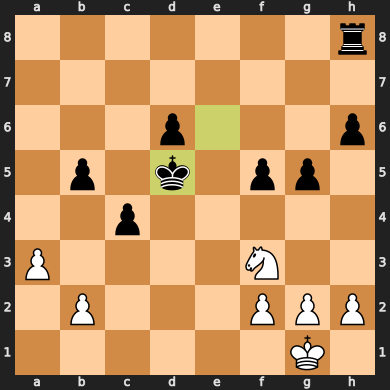

In [45]:
board.reset()

for move in game.mainline_moves():
    print(move.uci())
    print(chess.Color())
    print('from square: ' ,chess.square_name(move.from_square))
    print('to square: ' ,chess.square_name(move.to_square))
    print('drop: ' ,move.drop)
    print('is capture?' , board.is_capture(move))
    print('is en passant capture?' , board.is_en_passant(move))
    print('is kingside castle?' , board.is_kingside_castling(move))
    print('is quenside castle?' , board.is_queenside_castling(move))
    print('turn?' , board.turn)

    board.push(move)  # Make the move
    print('is_checkmate?' , board.is_checkmate())
    print('checkers' , board.checkers())
    print('outcome' , board.outcome())

    print(board)
    #print(board.piece_map())
board

<bound method GameNode.mainline_moves of <Game at 0x7f47345aac70 ('ddj' vs. 'kinner', '????.??.??')>>


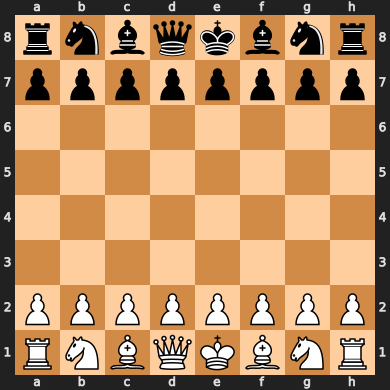

In [13]:
board.reset()
print(game.mainline_moves)
board

In [14]:
#piece.piece_type()

In [15]:
board.reset()
dict = board.piece_map()
dict

{63: Piece.from_symbol('r'),
 62: Piece.from_symbol('n'),
 61: Piece.from_symbol('b'),
 60: Piece.from_symbol('k'),
 59: Piece.from_symbol('q'),
 58: Piece.from_symbol('b'),
 57: Piece.from_symbol('n'),
 56: Piece.from_symbol('r'),
 55: Piece.from_symbol('p'),
 54: Piece.from_symbol('p'),
 53: Piece.from_symbol('p'),
 52: Piece.from_symbol('p'),
 51: Piece.from_symbol('p'),
 50: Piece.from_symbol('p'),
 49: Piece.from_symbol('p'),
 48: Piece.from_symbol('p'),
 15: Piece.from_symbol('P'),
 14: Piece.from_symbol('P'),
 13: Piece.from_symbol('P'),
 12: Piece.from_symbol('P'),
 11: Piece.from_symbol('P'),
 10: Piece.from_symbol('P'),
 9: Piece.from_symbol('P'),
 8: Piece.from_symbol('P'),
 7: Piece.from_symbol('R'),
 6: Piece.from_symbol('N'),
 5: Piece.from_symbol('B'),
 4: Piece.from_symbol('K'),
 3: Piece.from_symbol('Q'),
 2: Piece.from_symbol('B'),
 1: Piece.from_symbol('N'),
 0: Piece.from_symbol('R')}

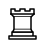

In [16]:
dict[0]

In [17]:
#creates a list with one entry for each space on the board
spaces = []
for i in range(1,9):
    for j in range (1,9):
        spaces.append(chr(j+96)+str(i))

In [117]:
#create a matrix to tally weights for every pair of opposing pieces
pieces_list = [space for space in spaces if any(map(space.__contains__, ['1','2','7','8']))]
weights = pd.DataFrame(0,index=pieces_list, columns=pieces_list)

In [118]:
#create a state dictionary of each square and the initial square of each piece
#Those 'None' entries are the empty squares in the middle of the board, before the first move
#Each piece is on it's own square to begin
state_dict = {space:(space  if any(map(space.__contains__, ['1','2','7','8'])) else None) for space  in spaces}

In [119]:
game_counter = 0
while game_counter < 10:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    #do stuff here


    counter = 0
    state_dict = {space:(space  if any(map(space.__contains__, ['1','2','7','8'])) else None) for space  in spaces}

    board.reset()
    #for each line in the file
    for move in game.mainline_moves():
        counter += 1
        # if the target square is occupied


        if board.outcome() is not None:
            print("checkmate")
            game_counter += 1
            print('end of game',game_counter)

            break


        elif board.is_capture(move):

            #record the kill in a matrix of all kills
            print(counter,chess.square_name(move.from_square), "takes on",chess.square_name(move.to_square))
            #what piece is there now?

            #increment an entry in the weights matrix when one piece takes another
            weights.loc[state_dict[chess.square_name(move.from_square)],state_dict[chess.square_name(move.to_square)]] += 1

            #update the piece on the target square
            state_dict[chess.square_name(move.to_square)] = state_dict[chess.square_name(move.from_square)]

            #update the source square to be empty
            state_dict[chess.square_name(move.from_square)] = None

            board.push(move)  # Make the move


            #if df.loc[i+1,'move_no'] == 1:
            #    state_dict = {space:(space  if any(map(space.__contains__, ['1','2','7','8'])) else None) for space  in spaces}


        else:

            #update the piece on the target square
            state_dict[chess.square_name(move.to_square)] = state_dict[chess.square_name(move.from_square)]

            #update the source square to be empty
            state_dict[chess.square_name(move.from_square)] = None

            #add castling special cases to record both moves
            if board.is_queenside_castling(move):
                if board.turn:
                    print(counter,'... and white castles kingside')
                    #move the appopriate rook
                    state_dict['f1'] = 'h1'
                    #leaving the rook source square empty
                    state_dict['h1'] = 'None'
                    board.push(move)  # Make the move



                elif not board.turn:
                    print(counter,'... and black castles kingside')
                    #move the appopriate rook
                    state_dict['f8'] = 'h8'
                    #leaving the rook source square empty
                    state_dict['h8'] = 'None'
                    board.push(move)  # Make the move

            elif board.is_kingside_castling(move):
                if board.turn:
                    print(counter,'... and white castles queenside')
                    #move the appopriate rook
                    state_dict['d1'] = 'a1'
                    #leaving the rook source square empty
                    state_dict['a1'] = 'None'
                    board.push(move)  # Make the move

                elif not board.turn:
                    print(counter,'... and black castles queenside')
                    #move the appopriate rook
                    state_dict['d8'] = 'a8'
                    #leaving the rook source square empty
                    state_dict['a8'] = 'None'
                    board.push(move)  # Make the move

            else:


                print(counter, chess.square_name(move.from_square),chess.square_name(move.to_square))

                board.push(move)  # Make the move




    #print(state_dict)
    #The board is mostly empty by the end of most games
    game_counter += 1
    print('end of game',game_counter)
    print('outcome',board.outcome())

1 e2 e4
2 e7 e5
3 f2 f4
4 f8 c5
5 g1 f3
6 d7 d6
7 f4 takes on e5
8 d6 takes on e5
9 c2 c3
10 b8 c6
11 d2 d4
12 e5 takes on d4
13 c3 takes on d4
14 c5 b4
15 b1 c3
16 c8 g4
17 f1 e2
18 g4 takes on f3
19 e2 takes on f3
20 d8 takes on d4
21 d1 takes on d4
22 c6 takes on d4
23 ... and white castles queenside
24 d4 takes on f3
25 f1 takes on f3


KeyError: None

In [111]:
weights

,a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,...,g7,h7,a8,b8,c8,d8,e8,f8,g8,h8
a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
b1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
d1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
g1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
h1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [112]:
#weights.drop(columns=['e1', 'e8'],inplace=True)
#weights.drop(index=['e1', 'e8'],inplace=True)

In [113]:
a = weights - np.identity(30)
print(a)

NameError: name 'np' is not defined

In [ ]:
b = np.zeros(30)
print(b)

In [ ]:
x = linalg.solve(a, b)
x

### Why doesn't it work?
### Because the solver is finding the trivial solution. i.e. just a vector full of zeroes.
### To check that there is actually a non trivial solution, the determinant of A must be non-zero.

In [ ]:
np.linalg.det(a)

### OK since the determinant is not zero, there must be at least one non-trivial solution. How to find it?
### An homogenous linear equation can be solved with a Matrix Factorization.

In [ ]:
eigen_values, eigen_vectors = np.linalg.eig(a)  

In [ ]:
values = eigen_vectors[:, np.argmin(eigen_values)] 

In [ ]:
## Let's normalize the values

In [ ]:
list = []
for i in values:
    list.append(abs(float(i)))

In [ ]:
#The fractional inverse of the strongest pawn
factor = 1 / np.max(list[7:-7])

In [ ]:
normed = [i*factor for i in list]

In [ ]:
normalized_list = ["%.2f"%i for i in normed]

In [ ]:
print(normalized_list[0:7])
print(normalized_list[7:7+8])
print(normalized_list[7+8:7+8+8])
print(normalized_list[-7:])